# Adaptive RAG

Adaptive RAG is a strategy for RAG that uses [query analysis](https://blog.langchain.dev/query-construction/) to route questions to various RAG approaches based on their complexity.

We will borrow some ideas from the [paper](https://arxiv.org/abs/2403.14403), shown in red (below):

* Perform query analysis to route questions

We will also build on some ideas from the Corrective RAG [paper](https://arxiv.org/pdf/2401.15884.pdf), shown in blue (below), and Self-RAG [paper](https://arxiv.org/abs/2310.11511), shown in red:

* Route between our index (vectorstore) and web-search
* Evaluate retrieved documents for relevance to the user question
* Evaluate LLM generations for faithfulness to the documents (e.g., ensure no hallucinations)
* Evaluate LLM generations for usefulness to the question (e.g., does it answer the question)

We implement these ideas from scratch using Mistral and [LangGraph](https://python.langchain.com/docs/langgraph):

* We use a graph to represent the control flow
* The graph state includes information (question, documents, etc) that we want to pass between nodes
* Each graph node modifies the state
* Each graph edge decides which node to visit next

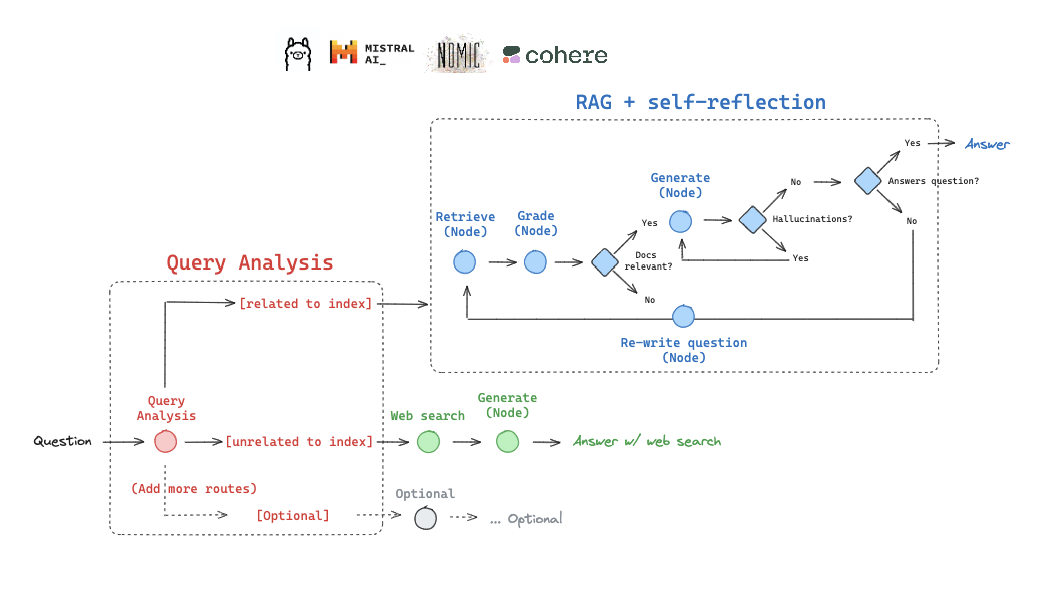

# Enviorment

In [10]:
! pip3 install -U --quiet langchain_community tiktoken langchain-upstage langchainhub chromadb langchain langgraph tavily-python python-dotenv

If using this in CoLab, set these:

### LLMs

We'll use the [Upstage API](https://console.upstage.ai/).

### Search

We'll use [Tavily Search](https://python.langchain.com/docs/integrations/tools/tavily_search) for web search.

In [11]:
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


## Index

Let's index 3 blog posts using [Chroma](https://www.trychroma.com/) and [Mistral embeddings](https://docs.mistral.ai/guides/embeddings/).

In [12]:
from pprint import pprint
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_upstage import UpstageEmbeddings as Embeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=Embeddings(),
)
retriever = vectorstore.as_retriever()

## LLMs

We can use Mistral function calling [to produce structured outputs](https://python.langchain.com/docs/modules/model_io/chat/structured_output/#mistral) at specific nodes.

It will use a flow like this:

![Screenshot 2024-04-10 at 10.51.13 AM.png](attachment:c1f293ca-cda8-4211-a133-2649771e411a.png)

In [13]:
### Set LLM
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_upstage import ChatUpstage as Chat

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "websearch"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM with function call
llm = Chat(temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. For all else, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(question_router.invoke({"question": "Who will the Bears draft first in the NFL draft?"}))
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='vectorstore'
datasource='vectorstore'


In [14]:
### Retrieval Grader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# LLM with function call
llm = Chat(temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
result = retrieval_grader.invoke({"question": question, "document": doc_txt})
pprint(result)

GradeDocuments(binary_score='yes')


In [15]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = Chat(temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
pprint(generation)

("In the context of LLM-powered autonomous agents, the agent's memory is "
 'divided into short-term and long-term memory. Short-term memory is utilized '
 'by the model to learn through in-context learning, while long-term memory '
 'allows the agent to retain and recall infinite information over extended '
 'periods, often by leveraging an external vector store and fast retrieval.')


In [16]:
### Hallucination Grader

# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

# LLM with function call
llm = Chat(temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
result = hallucination_grader.invoke({"documents": docs, "generation": generation})
pprint(result)

GradeHallucinations(binary_score='yes')


In [17]:
### Answer Grader

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")

# LLM with function call
llm = Chat(temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question,"generation": generation})

GradeAnswer(binary_score='yes')

## Web Search Tool

In [18]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

# Graph

We build the above workflow as a graph.

## Graph state

The graph `state` contains objects that we want to modify in the graph.

In [19]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question : str
    generation : str
    web_search : str
    documents : List[str]

Each node in our graph is a function that:

(1) Take `state` as an input

(2) Modifies `state` (e.g., using an LLM)

(3) Outputs the modified `state`

Each edge decides which node to visit next.

In [20]:
from langchain.schema import Document

### Nodes

def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score.binary_score
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}

### Edges

def route_question(state):
    """
    Route question to web search or RAG

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == 'websearch':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source.datasource == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score.binary_score

    # Check hallucination
    if grade and grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question,"generation": generation})

        if score and score.binary_score == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

## Build Graph

In [21]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generatae

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)

# Compile
app = workflow.compile()

In [22]:
inputs = {"question": "What plauyer are the Bears expected to draft in the NFL draft?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---


AttributeError: 'NoneType' object has no attribute 'binary_score'

Trace:

https://smith.langchain.com/public/93b441c2-cd72-4695-972c-e6062bd42765/r

In [ ]:
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])